In [1]:
from pathlib import Path
from matplotlib import gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime

#own modules
from evaluation.utils import db
from evaluation.visualization import plot
from evaluation.processing import tools_ec
con = db.connect()
'done'


from matplotlib.offsetbox import AnchoredOffsetbox, TextArea, HPacker, VPacker

        

<IPython.core.display.Javascript object>

Link selected experiments to publication:  HTE02_Database
 For table exp_sfc : inserted new experiments = 1 , skipped existing experiments = 0 
Link selected experiments to publication:  HTE02_Database
 For table exp_sfc : inserted new experiments = 1 , skipped existing experiments = 0 
Read data from "data_eis_analysis" ...
SELECT * FROM data_eis_analysis WHERE (`id_exp_sfc`) IN (7479);
Done in  0:00:00.064918
 Control quality of HFR extraction: 


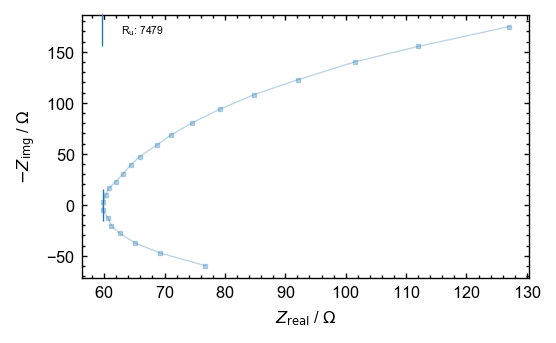

Matched experiment performed  9.887383333333334 min  earlier
Updated exp_ec with index: 7474 with ec_R_u_postdetermined__ohm= 59.8406  from id_exp_sfc= 7479
Link selected experiments to publication:  HTE02_Database
 For table exp_sfc : inserted new experiments = 0 , skipped existing experiments = 1 
Read data from "data_ec" ...
SELECT * FROM data_ec WHERE (`id_exp_sfc`) IN (7474) AND cycle IN (2);
Done in  0:00:00.029235
 File  20231009_processing_normalization.svg  already exists 


KeyboardInterrupt: Interrupted by user

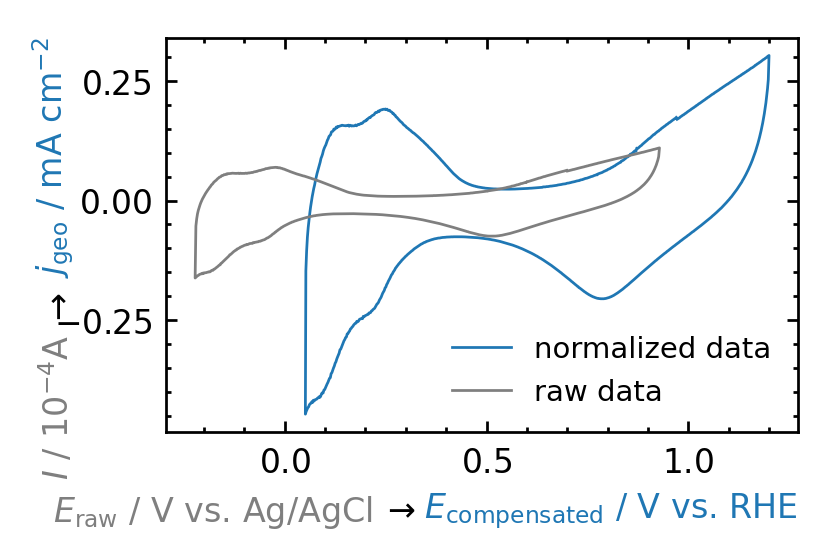

In [2]:
name='20231009_processing_normalization'
exp_ec = db.get_exp('''SELECT  *
                        FROM hte_data.exp_ec_expanded 
                        WHERE name_user="n.roettcher"
                            AND name_setup_sfc = "SFC_1"
                            AND DATE(t_start__timestamp) = "2023-10-06"
                            
                            # if known simply select experiments by number of performed batch
                            # AND id_ML = 60 

                            # alternatively define by other metadata
                            AND fe_top_id_pump_out_device = 'SFC' # not connected to ICP-MS
                            AND fe_top_pump_rate_out__rpm = 0 # no electrolyte flow
                            AND ec_name_technique="exp_ec_cv"
                            AND cv_scanrate__mV_s = 100
                            AND ROUND(cv_E_apex1__VvsRE + ec_E_RE__VvsRHE, 1) = 1.2 # or 1.6
                        ;
                        ''')

exp_ec = tools_ec.update_R_u__ohm(exp_ec, match_eis_id_ML=61, user_control=False) # derive uncompensated resistance from EIS experiemtn performed in id_ML=61

data_ec = db.get_data(exp_ec, 'data_ec', add_cond = 'cycle IN (2)')
data_ec = tools_ec.compensate_R_u(exp_ec, data_ec) # calculate compensated potentials
data_ec = tools_ec.geometric_current(exp_ec, data_ec, geo_cols='fc_top_name_flow_cell_A_opening_ideal__mm2') # calculate geometric current density

scale_raw_current = "1e-4"
data_ec.loc[:, 'I__'+scale_raw_current+'A'] = data_ec.loc[:, 'I__A'] / float(scale_raw_current)

with plt.rc_context(plot.get_style(style='singleColumn',
                                   fig_size={'width':6, 'height':4},
                                   add_margins_and_figsize= {'left': 0.1,  }, 
                                   interactive=True
                                  )):
    plot_storage=plot.PlotDataStorage(name, overwrite_existing=True)
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    
    color_raw = 'tab:grey'
    color_normalized = 'tab:blue'
    
    exp_ec = exp_ec.dataset\
                    .plot(x_col='E_WE__VvsRHE',
                         y_col='j__mA_cm2geo_fc_top_cell_Aideal',
                         data=data_ec,  
                         ax=ax1,
                          label='normalized data',
                          color='tab:blue',
                          axlabel_auto=False,
                        )\
                    .plot(x_col='E_WE_raw__VvsRE',
                         y_col='I__'+scale_raw_current+'A',
                         data=data_ec,    
                              ax=ax1,
                          label='raw data',
                          color='tab:grey',
                          axlabel_auto=False,
                        )\
                    .return_dataset()

    # User defined axis labels - make sure the descriptions belongs to the actual data columns plotted
    ybox_dict = dict(size=8,rotation=90,ha='left',va='bottom')
    ax1.add_artist(AnchoredOffsetbox(loc='upper center', 
                                      child=VPacker(children=[
                                                    TextArea("$j_\\mathrm{geo}$ / mA cm$^{-2}$", textprops=dict(color=color_normalized, **ybox_dict)),
                                                    TextArea(r"$\rightarrow$",     textprops=dict(color="black",  **ybox_dict)),
                                                    TextArea("$I$ / "+scale_raw_current.replace('e', '0$^{')+'}$'+"A", textprops=dict(color=color_raw,  **ybox_dict)),
                                                ],align="bottom", pad=0, sep=2),
                                      pad=0., 
                                      frameon=False, 
                                      bbox_to_anchor=(-0.18, 0.97),
                                      bbox_transform=ax1.transAxes, borderpad=0.)
                  )
    
    xbox_dict = dict(size=8, ha='left',va='center')
    ax1.add_artist(AnchoredOffsetbox(loc='right', 
                                      child=HPacker(children=[
                                                TextArea("$E_\\mathrm{raw}$ / V vs. Ag/AgCl", textprops=dict(color=color_raw, **xbox_dict)),
                                                TextArea(r"$\rightarrow$",     textprops=dict(color="black", **xbox_dict)),
                                                TextArea("$E_\\mathrm{compensated}$ / V vs. RHE", textprops=dict(color=color_normalized, **xbox_dict)),
                                               ],align="bottom", pad=0, sep=2), 
                                      pad=0., 
                                      frameon=False, 
                                      bbox_to_anchor=(1, -0.18),
                                      bbox_transform=ax1.transAxes, borderpad=0.)
                  )
    ax1.set_ylabel('')
    ax1.set_xlabel('')
    legend=ax1.legend()
    legend.get_frame().set_alpha(0)
    plot_storage.export(fig)
    
    plt.show()


exp_ec.dataset.display()
